# Week 03 Feature Engineering

In [175]:
import pandas as pd
import numpy as np
import ta as ta
from scipy.stats import zscore

In [176]:
row_data_path = '../../data/row/'
processed_data_path = '../../data/processed/'
NVDA_5_years_daily_data = pd.read_csv(
    row_data_path + 'NVDA_5_years_daily_data.csv', index_col='date', parse_dates=True)

In [177]:
data = NVDA_5_years_daily_data.rename(columns={"1. open": "open",
                                               "2. high": "high",
                                               "3. low": "low",
                                               "5. adjusted close": "close",
                                               "6. volume": "volume"})

## Feature Extraction

[Technical Analysis Library in Python](https://github.com/bukosabino/ta) 

Example adding all features:

In [ ]:
df = ta.add_all_ta_features(df=data.copy(), 
                            open="open",
                            high="high",
                            low="low",
                            close="close",
                            volume="volume")
df.to_csv(processed_data_path + "ta_all_features_data_NVDA.csv")

1. Convert volume to log space

In [179]:
data['log_volume'] = np.log(data['volume'])

2. Compute daily returns (difference)

In [180]:
data['daily_returns'] = data['close'].diff()

3. Calculate MA-5

Moving Average(MA)

<Axes: title={'center': 'NVDA Close Prices and MA-5'}, xlabel='date'>

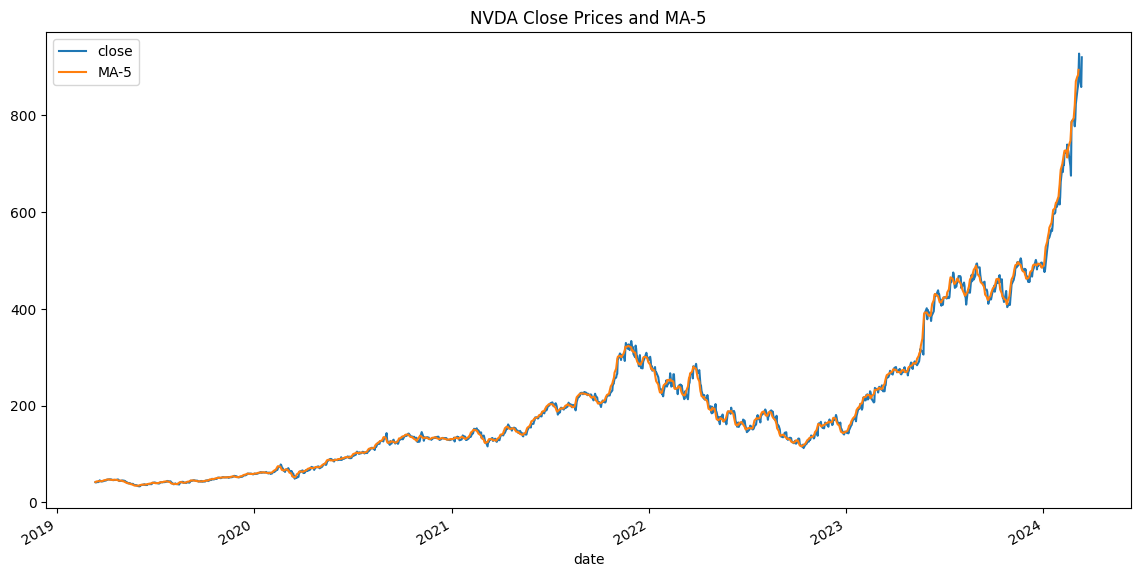

In [181]:
data['MA-5'] = data['close'].rolling(
    window=5).mean()

# Plotting MA-5 as an example
data[['close', 'MA-5']].plot(figsize=(14, 7), title="NVDA Close Prices and MA-5")

4. Calculate MA-30

In [182]:
data['MA-30'] = data['close'].rolling(window=30).mean()

5. Calculate Relative Strength Index (RSI)

The relative strength index (RSI) is a momentum indicator used in technical analysis. RSI measures the speed and magnitude of a security's recent price changes to evaluate overvalued or undervalued conditions in the price of that security.

The RSI can do more than point to overbought and oversold securities. It can also indicate securities that may be primed for a trend reversal or corrective pullback in price. It can signal when to buy and sell. Traditionally, 
- an RSI reading of 70 or above indicates an overbought situation. 
- A reading of 30 or below indicates an oversold condition.

When date number doesn't accumulate to 14:

$$
R S I_{\text {step one }}=100-\left[\frac{100}{1+\frac{\text { Average gain }}{\text { Average loss }}}\right]
$$

Once there are 14 periods of data available, the second calculation can be done. 

$$
R S I_{\text {step two }}=100-\left[\frac{100}{1+\frac{\text { (Previous Average Gain } \times 13)+ \text { Current Gain }}{(\text { (Previous Average Loss } \times 13)+\text { Current Loss })}}\right]
$$

In [183]:
RSI = ta.momentum.RSIIndicator(data['close'], window=14)
data['RSI'] = RSI.rsi()

6. Calculate 5-day variance

In [184]:
data['5-day_variance'] = data['close'].rolling(window=5).var()

7. Calculate Williams %R

Williams %R, also known as the Williams Percent Range, is a type of momentum indicator that moves between 0 and -100 and measures overbought and oversold levels. 

The Williams %R may be used to find entry and exit points in the market. The indicator is very similar to the Stochastic oscillator and is used in the same way. It was developed by Larry Williams and it compares a stock’s closing price to the high-low range over a specific period, typically 14 days or periods.

The Formula for the Williams \%R Is:
$$
\text { Wiliams } \% R=\frac{\text { Highest High }- \text { Close }}{\text { Highest High }- \text { Lowest Low }}
$$

In [185]:
WILLR = ta.momentum.WilliamsRIndicator(high=data['high'],
                                       low=data['low'],
                                       close=data['close'],
                                       lbp=14)
data['Williams_%R'] = WILLR.williams_r()

8. Calculate z-score for daily close prices

$$
Z = \frac{x - \mu}{\sigma}
$$

In [186]:
data['z_score'] = (data['close'] - data['close'].rolling(window=10).mean()
                   ) / data['close'].rolling(window=10).std()

9. Simple Moving Average

In [187]:
data['SMA10'] = data['close'].rolling(window=10).mean()

10. Exponential Moving Average (EMA)

An exponential moving average (EMA) is a type of moving average (MA) that places a greater weight and significance on the most recent data points.

The exponential moving average is also referred to as the exponentially weighted moving average. An exponentially weighted moving average reacts more significantly to recent price changes than a simple moving average simple moving average (SMA), which applies an equal weight to all observations in the period.

$$
\begin{aligned}
E M A_{\text {Today }}= & \left(\text { Value }_{\text {Today }} \times \left(\frac{\text { Smoothing }}{1+\text { Days }}\right)\right) +E M A_{\text {Yesterday }} \times \left(1-\left(\frac{\text { Smoothing }}{1+\text { Days }}\right)\right)
\end{aligned}
$$
where:
$E M A=$ Exponential moving average

While there are many possible choices for the smoothing factor, the most common choice is:
- Smoothing $=2$

In [188]:
data['EMA12'] = data['close'].ewm(span=12, adjust=False).mean()

11. Moving Average Convergence Divergence (MACD)

Moving average convergence/divergence (MACD) is a technical indicator to help investors identify price trends, measure trend momentum, and **identify market entry points for buying or selling**. Moving average convergence/divergence (MACD) is a trend-following momentum indicator that shows the relationship between two exponential moving averages (EMAs) of a security’s price. MACD was developed in the 1970s by Gerald Appel.

In [189]:
MACD = ta.trend.MACD(close=data['close'], window_fast=12, window_slow=26)
data['MACD'] = MACD.macd()

12. Return on capital

$$
\text { Return on capital }=\frac{\text { Net income }}{\text { Debt }+ \text { Equity }}
$$

In [190]:
RoC = ta.momentum.ROCIndicator(close=data['close'], window=1)
data['RoC'] = RoC.roc()

13. K15

The K-ratio is a valuation metric that examines the consistency of an equity's return over time. The data for the ratio is derived from a value-added monthly index (VAMI), which uses linear regression to track the progress of a $1,000 initial investment in the security being analyzed.

In [191]:
low_min = data['low'].rolling(window=15).min()
high_max = data['high'].rolling(window=15).max()
data['K15'] = ((data['close'] - low_min) /
               (high_max - low_min)) * 100

14. Bollinger Bands

A Bollinger Band® is a technical analysis tool defined by a set of trendlines. They are plotted as two standard deviations, both positively and negatively, away from a simple moving average (SMA) of a security's price and can be adjusted to user preferences.

Bollinger Bands® was developed by technical trader John Bollinger and designed to give investors a higher probability of identifying when an asset is oversold or overbought.

In [192]:
data['Bollinger_M'] = data['close'].rolling(window=20).mean()
data['Bollinger_U'] = data['Bollinger_M'] + \
    2 * data['close'].rolling(window=20).std()
data['Bollinger_L'] = data['Bollinger_M'] - \
    2 * data['close'].rolling(window=20).std()

15. MOM12



In [193]:
data['MOM12'] = data['close'] - data['close'].shift(12)

In [194]:
# Save the enhanced dataset
data.to_csv(processed_data_path + 'features_NVDA.csv')

print("Enhanced dataset saved successfully.")

Enhanced dataset saved successfully.


In [195]:
data.dropna(inplace=True)
data

,open,high,low,4. close,close,volume,7. dividend amount,8. split coefficient,log_volume,daily_returns,...,z_score,SMA10,EMA12,MACD,RoC,K15,Bollinger_M,Bollinger_U,Bollinger_L,MOM12
date,,,,,,,,,,,,,,,,,,,,,
2024-01-30,629.00,634.93,622.60,627.74,627.710792,41073530.0,0.0,1.0,17.530874,12.469420,...,-1.206569,675.132585,676.904555,-53.870317,2.026752,14.888068,709.234499,815.146584,603.322413,-98.835401
2024-01-29,612.32,624.89,609.07,624.65,624.620936,34873298.0,0.0,1.0,17.367232,-3.089856,...,-1.061160,665.350041,668.860921,-54.050696,-0.492242,12.666908,701.116876,806.828213,595.405539,-114.344679
2024-01-26,609.60,617.83,605.73,610.31,610.281603,39030859.0,0.0,1.0,17.479863,-14.339333,...,-1.207689,654.248557,659.848719,-54.719935,-2.295686,3.242344,692.086796,796.356608,587.816985,-110.964837
2024-01-25,623.50,627.19,608.50,616.17,616.141330,48277684.0,0.0,1.0,17.692480,5.859727,...,-0.861998,646.224930,653.124505,-54.153235,0.960168,7.416534,683.487197,782.648559,584.325835,-106.305054
2024-01-24,603.04,628.49,599.38,613.62,613.591449,55706870.0,0.0,1.0,17.835614,-2.549881,...,-0.788427,637.488337,647.042496,-53.295519,-0.413847,9.685442,674.899596,766.369942,583.429250,-107.704988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-19,172.76,177.50,172.08,175.71,43.629332,21374310.0,0.0,1.0,16.877700,0.325277,...,-0.633832,44.143071,44.515617,-0.179477,0.751147,-587.739364,45.539031,48.785414,42.292648,-3.116203
2019-03-18,171.08,173.25,167.86,168.95,41.950803,12174829.0,0.0,1.0,16.314881,-1.678529,...,-1.929590,43.812083,44.121030,-0.370783,-3.847248,-529.252613,45.343492,48.958283,41.728701,-4.884121
2019-03-15,167.30,171.53,167.16,169.81,42.164344,16536482.0,0.0,1.0,16.621080,0.213541,...,-1.339881,43.569988,43.820001,-0.499406,0.509026,-524.310638,45.092706,48.863592,41.321820,-3.275117


## Feature Engineering

In [196]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import tree
import numpy as np

### Step 1: Time Series Split

In [197]:
# Define features and target variable
X = data.drop(['close', '4. close'], axis=1)
y = data['close']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

### Step 2: Gradient Boosting Regression

Train a Gradient Boosting Regression model within a cross-validation loop, compute RMSE for each split, and use PCA if necessary due to high dimensionality:

In [198]:
rmse_scores = []

for test_train, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[test_train], X_scaled[test_index]
    y_train, y_test = y.iloc[test_train], y.iloc[test_index]

    # Train the model
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate RMSE and append to scores list
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

print(f"Average RMSE: {np.mean(rmse_scores)}")

Average RMSE: 83.08051386521592


### Step 3: Feature Importance and Model Comparison

After training, extract feature importance and consider removing low-importance features or testing other models for comparison:

In [199]:
feature_importance = model.feature_importances_
# Filter or modify features based on importance as needed
feature_names = X.columns

# Combine feature names and their importances into a DataFrame for easier analysis
importances_df = pd.DataFrame(
    {'Feature': feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Display the sorted importances
print("Feature Importances:")
print(importances_df)
feature_names

Feature Importances:
                 Feature  Importance
8                   MA-5    0.891644
2                    low    0.042607
1                   high    0.023740
15                 EMA12    0.012313
0                   open    0.009667
20           Bollinger_U    0.006564
9                  MA-30    0.006527
14                 SMA10    0.002301
21           Bollinger_L    0.002251
13               z_score    0.001000
19           Bollinger_M    0.000638
12           Williams_%R    0.000383
7          daily_returns    0.000134
17                   RoC    0.000109
11        5-day_variance    0.000081
22                 MOM12    0.000011
18                   K15    0.000008
10                   RSI    0.000007
16                  MACD    0.000006
3                 volume    0.000005
6             log_volume    0.000004
5   8. split coefficient    0.000000
4     7. dividend amount    0.000000


Index(['open', 'high', 'low', 'volume', '7. dividend amount',
       '8. split coefficient', 'log_volume', 'daily_returns', 'MA-5', 'MA-30',
       'RSI', '5-day_variance', 'Williams_%R', 'z_score', 'SMA10', 'EMA12',
       'MACD', 'RoC', 'K15', 'Bollinger_M', 'Bollinger_U', 'Bollinger_L',
       'MOM12'],
      dtype='object')

### Step 4: Reducing the Dimensions with Set Threshold

Option 1:

In [217]:
# Define a threshold below which features are considered of low importance
# For demonstration, using 0.01 (1%) as the threshold
threshold = 0.001

# Identify features with importance below the threshold
low_importance_features = importances_df[importances_df['Importance']
                                         < threshold]['Feature']

X_filtered1 = X.drop(columns=low_importance_features)

Option 2:

In [218]:
correlation_matrix = X.corr()

threshold = 0.9

highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

print("Highly correlated features:", highly_correlated_features)

X_filtered2 = X.drop(columns=highly_correlated_features)

Highly correlated features: {'SMA10', 'K15', 'Bollinger_L', 'log_volume', 'low', 'high', 'MA-30', 'EMA12', 'Bollinger_U', 'Bollinger_M'}


In [213]:
def test_train(X, y, model_func=GradientBoostingRegressor()):
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    rmse_scores = []

    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model = model_func
        model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Calculate RMSE and append to scores list
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

    print(f"Average RMSE: {np.mean(rmse_scores)}")
    feature_importance = model.feature_importances_
    # Filter or modify features based on importance as needed
    feature_names = X.columns

    # Combine feature names and their importances into a DataFrame for easier analysis
    importances_df = pd.DataFrame(
        {'Feature': feature_names, 'Importance': feature_importance})

    # Sort the DataFrame by importance in descending order
    importances_df.sort_values(by='Importance', ascending=False, inplace=True)

    # Display the sorted importances
    print("Feature Importances:")
    print(importances_df)

In [219]:
# Option 1
test_train(X_filtered1, y=y)

Average RMSE: 84.79242480986895
Feature Importances:
       Feature  Importance
3         MA-5    0.893339
2          low    0.044194
1         high    0.023780
6        EMA12    0.012757
0         open    0.009913
4        MA-30    0.006838
7  Bollinger_U    0.006542
5        SMA10    0.002249
8  Bollinger_L    0.000388


In [220]:
# Option 2
test_train(X_filtered2, y=y)

Average RMSE: 76.44196731799408
Feature Importances:
                 Feature    Importance
5                   MA-5  9.461296e-01
0                   open  5.173438e-02
9                z_score  1.107567e-03
8            Williams_%R  4.816399e-04
4          daily_returns  2.031899e-04
11                   RoC  1.466588e-04
7         5-day_variance  1.115346e-04
1                 volume  2.810622e-05
10                  MACD  2.754112e-05
12                 MOM12  1.888351e-05
6                    RSI  1.061562e-05
2     7. dividend amount  3.195914e-07
3   8. split coefficient  0.000000e+00


### Step 5: PCA for Dimensionality Reduction

If the feature dimension is too large, you might consider applying PCA before training:

In [205]:
# Apply PCA
# Retain 95% of variance or choose the number of components
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Transform PCA results into a DataFrame with meaningful column names
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
# Ensure to match the original index
X_pca_df = pd.DataFrame(X_pca, columns=pca_columns, index=X.index)

# Now X_pca_df can be used for further analysis or modeling
print(X_pca_df.head())

                  PC1       PC2       PC3       PC4       PC5       PC6  \
date                                                                      
2024-01-30  11.768584  3.795726  0.339991 -3.948547 -0.729412  0.065153   
2024-01-29  10.779546  4.329662  1.270286 -2.579493 -0.203480  0.054095   
2024-01-26  10.450967  4.519557  2.050041 -1.402683 -0.044201 -0.006534   
2024-01-25  10.279822  3.753403  0.368083 -3.313611  0.093792  0.195549   
2024-01-24  10.308375  3.704569  1.022974 -2.402368  0.040738  0.108888   

                 PC7       PC8       PC9  
date                                      
2024-01-30  6.303305  0.507095  0.546658  
2024-01-29  0.977580 -1.158515 -0.862616  
2024-01-26 -0.897449 -1.725984 -1.395414  
2024-01-25 -1.178938 -1.274401 -0.291720  
2024-01-24 -1.138463 -1.346010 -0.594912  


In [206]:
test_train(X=X_pca_df, y=y)

Average RMSE: 48.988773942734305
Feature Importances:
  Feature  Importance
0     PC1    0.950399
7     PC8    0.020089
2     PC3    0.018127
1     PC2    0.007911
6     PC7    0.001870
3     PC4    0.000961
8     PC9    0.000289
4     PC5    0.000184
5     PC6    0.000171


### Step 6: Encapsulating the Process
Finally, encapsulate your data preprocessing, model training, and prediction steps into a function for reuse:

In [207]:
def train_and_predict(data, model_func=GradientBoostingRegressor()):
    data = data.rename(columns={"1. open": "open",
                                "2. high": "high",
                                "3. low": "low",
                                "5. adjusted close": "close",
                                "6. volume": "volume"})
    data.dropna(inplace=True)
    
    # Define features and target variable
    X = data.drop(['close', '4. close'], axis=1)
    y = data['close']
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Retain 95% of variance or choose the number of components
    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)

    X_scaled = scaler.fit_transform(X_pca)
    
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    rmse_scores = []

    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model = model_func
        model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Calculate RMSE and append to scores list
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

    print(f"Average RMSE: {np.mean(rmse_scores)}")

In [208]:
train_and_predict(NVDA_5_years_daily_data, model_func=GradientBoostingRegressor())

Average RMSE: 166.45262158498974


In [209]:
train_and_predict(NVDA_5_years_daily_data, model_func=LinearRegression())

Average RMSE: 256832.21191620763


In [210]:
train_and_predict(NVDA_5_years_daily_data, model_func=tree.DecisionTreeRegressor())

Average RMSE: 185.90798710116218
